# imports

In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

import ColorDataUtils.mattplotlib as mplt
from NDNT.utils import imagesc   # because I'm lazy

class Model:
    def __init__(self, ndn_model, LLs):
        self.ndn = ndn_model
        self.LLs = LLs
from models import iter_core, iter_0715_1x

device = torch.device("cuda:1")

datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils


ImportError: cannot import name 'iter_0715_1x' from 'models' (/home/mattjac/projects/mattjac/v1/core paper/models.py)

In [27]:
iter_core.ndn_model.networks[0].layers[-1].__dict__

{'window': False,
 'tent_basis': None,
 'training': False,
 '_parameters': OrderedDict([('weight',
               Parameter containing:
               tensor([[-0.0393,  0.1071, -0.0393,  ...,  0.0279, -0.0615,  0.0088],
                       [-0.0267,  0.0469, -0.0552,  ...,  0.0802, -0.0324,  0.0236],
                       [-0.0464, -0.0009, -0.0883,  ...,  0.0902, -0.0176,  0.0565],
                       ...,
                       [-0.0112,  0.0200, -0.0579,  ...,  0.0508, -0.0423, -0.0331],
                       [ 0.0122,  0.0117, -0.0591,  ...,  0.0514, -0.0210, -0.0422],
                       [ 0.0337, -0.0008, -0.0476,  ...,  0.0638,  0.0070, -0.0380]],
                      requires_grad=True))]),
 '_buffers': OrderedDict([('bias',
               tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),
              (

In [22]:
np.mean(iter_core.LLs), np.mean(iter_0715_1x.LLs)

(0.030168511, 0.03160584)

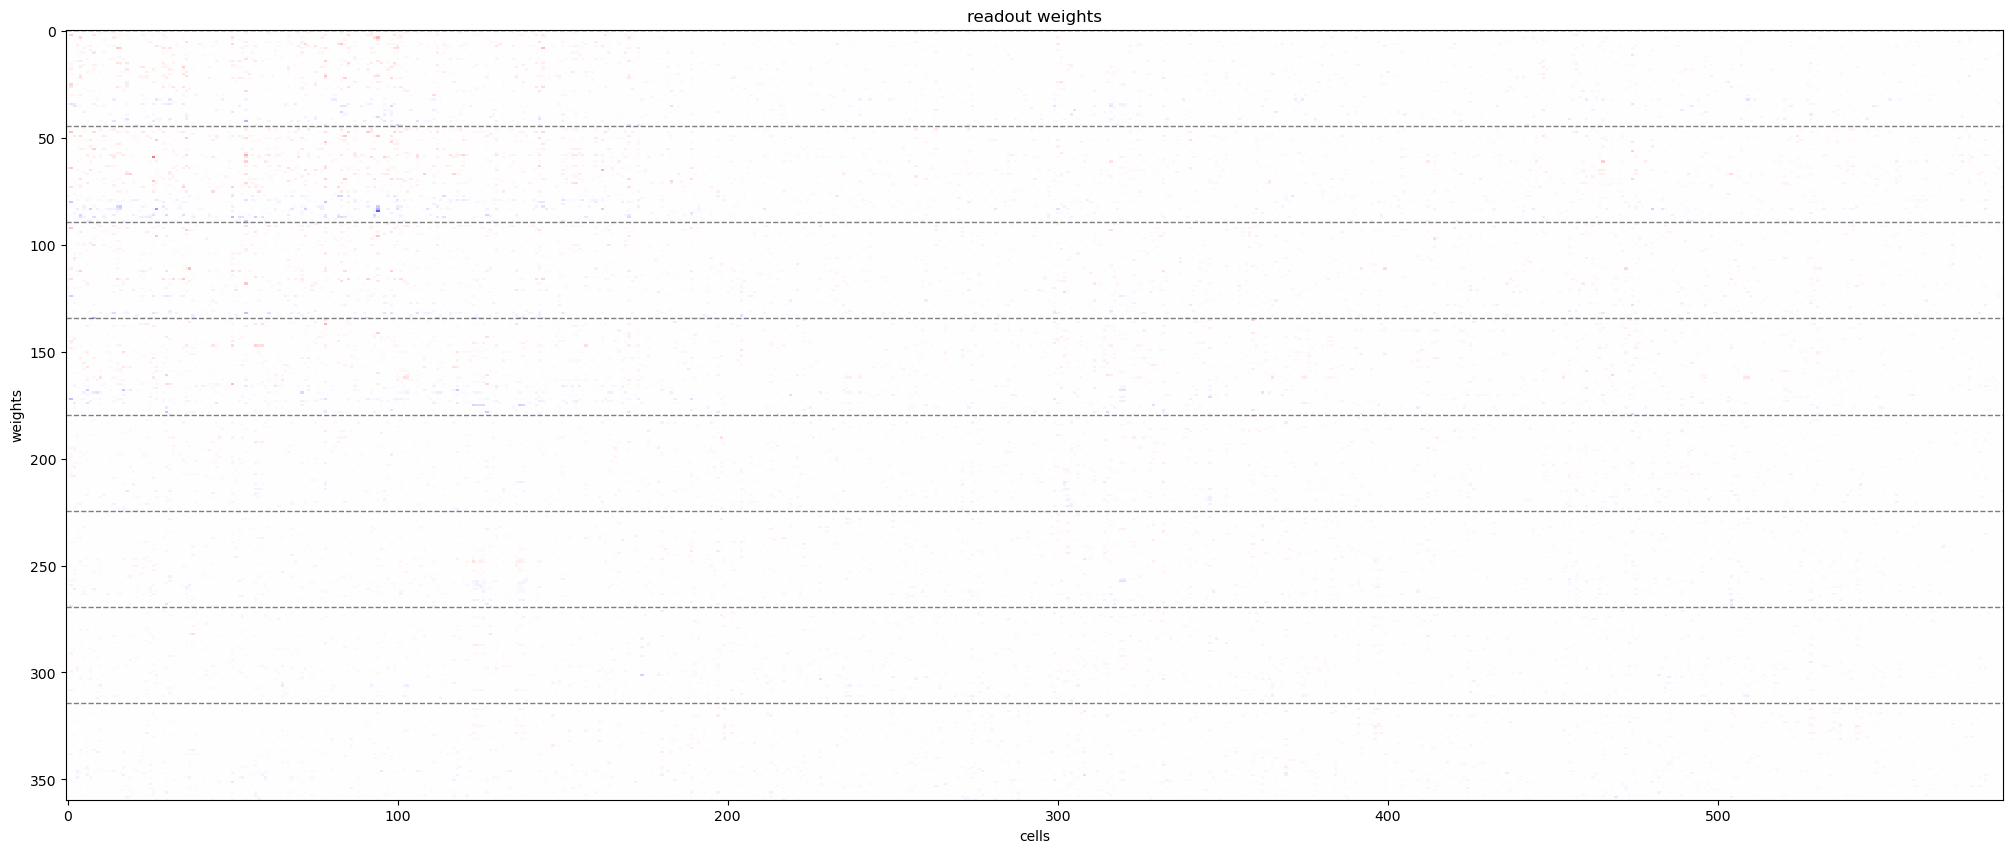

(array([  0,  45,  90, 135, 180, 225, 270, 315, 360]),
 array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          7.9451213e-13,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          2.3766022e-42,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  1.8448211e-01,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  4.4390839e-02],
        ...,
        [-9.0829283e-27, -3.5784016e-03, -1.4012985e-45, ...,
         -5.1088381e-19, -1.0609435e-24, -6.2723245e-08],
        [-1.8478237e-02, -4.0670234e-04, -1.1747364e-16, ...,
         -9.4175191e-18, -2.0057666e-07, -5.9139500e-27],
        [-4.0584422e-13, -2.2420775e-44, -3.1017449e-14, ...,
         -1.1362247e-20, -6.7434303e-09, -1.3074393e-24]], dtype=float32))

In [23]:
mplt.plot_readout_weights(iter_core.ndn_model)

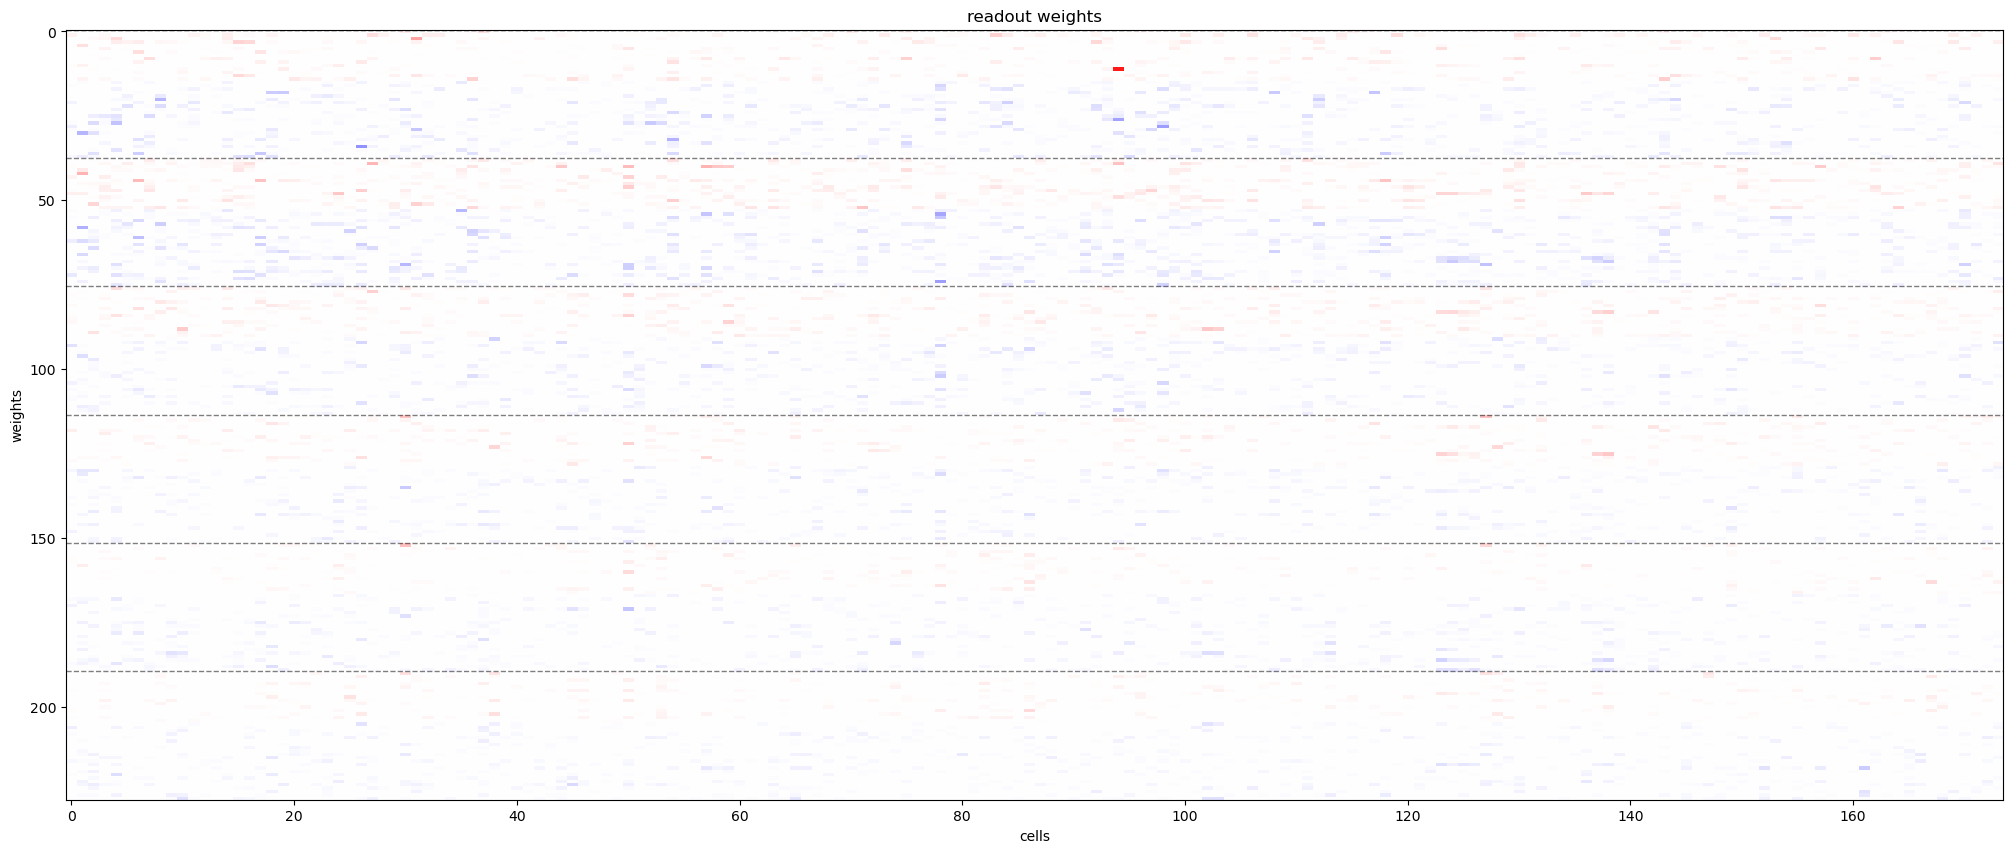

(array([  0,  38,  76, 114, 152, 190, 228]),
 array([[ 1.3148711e-27,  0.0000000e+00,  3.8143344e-42, ...,
          1.1921849e-37,  6.0660397e-03,  8.3925166e-18],
        [ 5.2933052e-02,  8.0154272e-43,  0.0000000e+00, ...,
          4.7444176e-02,  7.1247430e-10,  6.3056052e-03],
        [ 3.0667759e-03,  9.8196482e-34,  2.1883799e-02, ...,
          1.7045525e-10,  0.0000000e+00,  4.7798042e-12],
        ...,
        [-1.8248110e-10, -1.7407349e-10, -8.8378857e-04, ...,
         -2.3753585e-02, -8.5609493e-09, -5.6037307e-03],
        [-0.0000000e+00, -1.6250314e-02, -1.6915949e-02, ...,
         -2.9636474e-11, -1.4627440e-04, -8.4048202e-10],
        [-6.9271158e-11, -1.9307645e-03, -2.8875441e-08, ...,
         -1.2355199e-17, -3.1009308e-04, -3.2588474e-08]], dtype=float32))

In [24]:
mplt.plot_readout_weights(iter_0715_1x.ndn_model)